# Adiabatic quantum state preparation

Here we demonstrate how adiabatic state preparation method can be used to prepare the bell state on a hybrid platform. The bell state ${|00\rangle + |11\rangle}/{\sqrt{2}} $ can be taken to be the ground state of the following target Hamiltonian, $ H_{f}= J \sigma_{z}^1 \sigma_{z}^2$. We choose our initial hamiltonoan as $H_{i}=h_0 (\sigma_{x}^1 + \sigma_{x}^2)$. The total Hamiltonian can be written as, 

$$H(\beta) = (1-\beta) \left(h_0 (\sigma_{x}^1 + \sigma_{x}^2)\right) + \beta J \sigma_{z}^1 \sigma_{z}^2$$


In [273]:
# make the imports that are necessary for our work
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q')
import qiskit.tools.jupyter
#%qiskit_job_watcher

WARNING - Credentials are already in use. The existing account in the session will be replaced.


In [427]:
from scipy.optimize import minimize 
import random
import itertools
num_qubit=2 # Number of qubits, same program can be used to prepare GHZ state.
dt = 0.1  # Time step
T = 0.2 # Total Simulation time 
h0 =-1 # x-magnetic field
J=-1 # Strength of coupling
cost_list=[]
n= int(round(T/dt))

theta_x = [0]*(n)

def circuit_ansatz(theta):        
        # Create the quantum circuit
        q = QuantumRegister(num_qubit)
        c = ClassicalRegister(num_qubit)
        qc = QuantumCircuit(q, c)
        
        # Create equal super-position
        qc.h(range(num_qubit))
        qc.barrier()
        for i in range(len(theta_x)):  
          for l in range(num_qubit-1):
               qc.cx(l,l+1)
               #qc.rz(theta[i],l+1)
               qc.ry(-pi/2, l+1)
               qc.rx(theta[i], l+1)
               qc.ry(pi/2, l+1)
               qc.cx(l,l+1)
               qc.barrier()
          qc.rx(1-theta[i], range(num_qubit))
          qc.barrier()      
        #Measure
        qc.barrier()
        qc.measure(q, c)
        
        #backend = provider.get_backend('ibmq_essex')
        backend = Aer.get_backend('qasm_simulator')
        Num_Shots=100
        job_sim = execute(qc, backend, shots=Num_Shots)
        result_sim = job_sim.result()
        counts=result_sim.get_counts(qc)
        p = {}
        binary_states = ["".join(map(str, list(i))) for i in itertools.product([0, 1], repeat=num_qubit)]
        for i, val in enumerate(binary_states):
            if val in counts.keys():
                p[i] = counts[val] / Num_Shots
            else:
                p[i] = 0
            
        sum = 0
        for i in range(1, len(p)-1):
            sum += p[i]
            
        p = list(p.values())
        cost=J*(p[0]+p[-1]-sum)
        global cost_list
        cost_list.append(cost)
        #print(cost, theta)
        return cost   
#Initial Value for theta
# random_list =random.sample(range(0, 1), 2)
res = [] 
for j in range(n): 
    res.append(random.randint(0,9)) 

theta_initial = res

#Optimization
#res = minimize(circuit_ansatz, theta_initial, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res = minimize(circuit_ansatz, theta_initial, method='powell')

#Output
print(res, 'optm_angles')
optimum_value=res.x

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [ 6.74451116e-03, -3.50412679e-05]])
     fun: array(-1.)
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  status: 0
 success: True
       x: array([-1.77512584, -0.10396663]) optm_angles


{'11': 4862, '10': 115, '01': 110, '00': 4913}


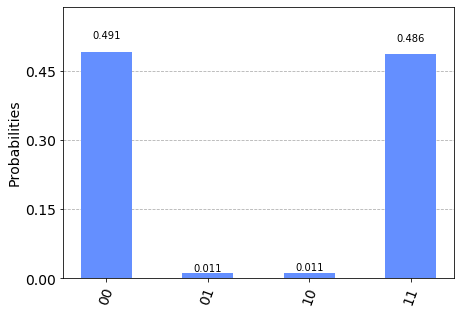

In [432]:
theta=optimum_value
cost_list=[]

# Create the quantum circuit
q = QuantumRegister(num_qubit)
c = ClassicalRegister(num_qubit)
qc = QuantumCircuit(q, c)
        
# Create equal super-position
qc.h(range(num_qubit))
qc.barrier()
for i in range(len(theta_x)): 
  for l in range(num_qubit-1):
       qc.cx(l,l+1)
       #qc.rz(theta[i],l+1)
       qc.ry(-pi/2, l+1)
       qc.rx(theta[i], l+1)
       qc.ry(pi/2, l+1)
       qc.cx(l,l+1)
       qc.barrier()
  qc.rx(1-theta[i], range(num_qubit))
  qc.barrier()      
#Measure
qc.measure(q, c)
        
#backend = provider.get_backend('ibmq_ourense')
backend = Aer.get_backend('qasm_simulator')

job_sim = execute( qc, backend, shots=10000)
#job_sim = execute( qc, backend)


sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)
#qk.visualization.circuit_drawer(qc,2.3,filename='n2')
#qc.draw()

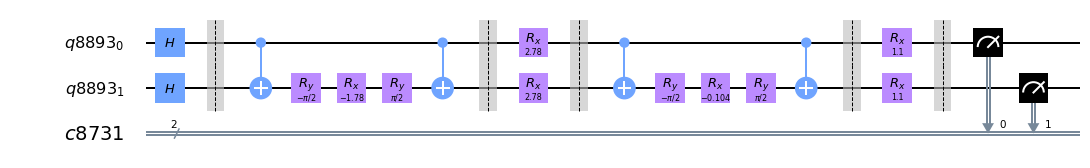

In [430]:
qc.draw()

__Angles=[-1.77512584, -0.10396663]__

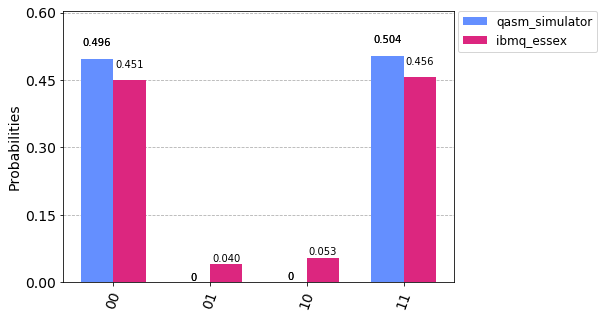

In [63]:
plot_histogram([measurement_result1, measurement_result], legend=['qasm_simulator', 'ibmq_essex '] )# Draw the circuit

__Simulation performed on IBM's 5-qubit quantum processor ibmq_essex__

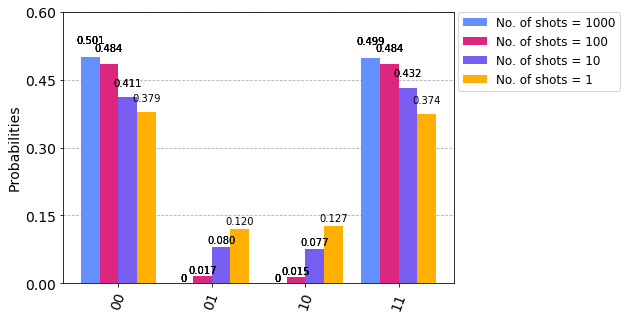

In [415]:
plot_histogram([measurement_result4, measurement_result3, measurement_result2, measurement_result1], legend=['No. of shots = 1000', 'No. of shots = 100', 'No. of shots = 10', 'No. of shots = 1'] )# Draw the circuit

# VQE for state preparation

In [489]:
#Import libraries
from grove.pyvqe.vqe import VQE
import numpy as np
from scipy.optimize import minimize
from pyquil import Program, get_qc

In [493]:
# Define Hamiltonian
from pyquil.paulis import PauliSum, PauliTerm
H = PauliSum([PauliTerm.from_list([("Z", 1), ("Z", 0)], coefficient=-1)])

In [494]:
# Define ansatz
n_qubits=2 
depth = 2

from pyquil.gates import RY, CNOT

#Choose ansatz
def ansatz(params):
    p = Program()
    for i in range(depth):
        for j in range(n_qubits):
            p += Program(RY(params[j], j))
        p += CNOT(0,1)
    return p

In [495]:
# Minimize and get approximate of the lowest eigenvalue
from grove.pyvqe.vqe import VQE
qc = get_qc('2q-qvm')
vqe = VQE(minimizer=minimize, minimizer_kwargs={'method': 'nelder-mead','options': {'xatol': 1.0e-2}})

In [528]:
np.random.seed(999)
initial_params = np.random.uniform(0.0, 2*np.pi, size=n_qubits)
result1 = vqe.vqe_run(ansatz, H, initial_params, samples=1)
print(result1)

{'x': array([5.04808726, 3.31452034]), 'fun': -1.0}


In [518]:
print(ansatz(result.x))

RY(6.278312037015378) 0
RY(3.1649785019058663) 1
CNOT 0 1
RY(6.278312037015378) 0
RY(3.1649785019058663) 1
CNOT 0 1



In [519]:
print('For samples=1',result1)
print('For samples=10',result2)
print('For samples=100',result3)
print('For samples=1000',result4)

For samples=1 {'x': array([5.04808726, 3.31452034]), 'fun': -1.0}
For samples=10 {'x': array([5.1664018 , 3.24978361]), 'fun': -1.0}
For samples=100 {'x': array([6.18390689, 3.14879432]), 'fun': -1.0}
For samples=1000 {'x': array([6.24700798, 3.14879432]), 'fun': -1.0}


__We can perform bell basis measurement at the end to make sure that we produced ${|00\rangle + |11\rangle}/{\sqrt{2}} $  and not  ${|00\rangle - |11\rangle}/{\sqrt{2}} $.__